In [ ]:
# fastf1 install
!pip install fastf1

In [ ]:
# old matplotlib version needed
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
# set up
import numpy as np
import pandas as pd

import fastf1 as ff1
from fastf1 import plotting

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from google.colab import files

In [ ]:
# Load the session data
quali = ff1.get_session(2022, 'Abu Dhabi', 'Q')

# Get the laps
laps = quali.load_laps(with_telemetry=True)


NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

/usr/local/lib/python3.8/dist-packages/fastf1/core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"


In [ ]:
# Setting parameters
driver_1, driver_2 = 'LEC', 'VER'

distance_min, distance_max = 4800, 5500 

In [ ]:
# Extracting the laps
laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)

telemetry_driver_1 = laps_driver_1.pick_fastest().get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.pick_fastest().get_car_data().add_distance()

# Identifying the team for coloring later on
team_driver_1 = laps_driver_1.reset_index().loc[0, 'Team']
team_driver_2 = laps_driver_2.reset_index().loc[0, 'Team']

In [ ]:
# Assigning labels to what the drivers are currently doing 
telemetry_driver_1.loc[telemetry_driver_1['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_1.loc[telemetry_driver_1['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_1.loc[(telemetry_driver_1['Brake'] == 0) & (telemetry_driver_1['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

telemetry_driver_2.loc[telemetry_driver_2['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_2.loc[telemetry_driver_2['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_2.loc[(telemetry_driver_2['Brake'] == 0) & (telemetry_driver_2['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

In [ ]:
# Numbering each unique action to identify changes, so that we can group later on
telemetry_driver_1['ActionID'] = (telemetry_driver_1['CurrentAction'] != telemetry_driver_1['CurrentAction'].shift(1)).cumsum()
telemetry_driver_2['ActionID'] = (telemetry_driver_2['CurrentAction'] != telemetry_driver_2['CurrentAction'].shift(1)).cumsum()

In [ ]:
# Identifying all unique actions
actions_driver_1 = telemetry_driver_1[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()
actions_driver_2 = telemetry_driver_2[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()

actions_driver_1['Driver'] = driver_1
actions_driver_2['Driver'] = driver_2

In [ ]:
# Calculating the distance between each action, so that we know how long the bar should be
actions_driver_1['DistanceDelta'] = actions_driver_1['Distance'] - actions_driver_1['Distance'].shift(1)
actions_driver_1.loc[0, 'DistanceDelta'] = actions_driver_1.loc[0, 'Distance']

actions_driver_2['DistanceDelta'] = actions_driver_2['Distance'] - actions_driver_2['Distance'].shift(1)
actions_driver_2.loc[0, 'DistanceDelta'] = actions_driver_2.loc[0, 'Distance']

In [ ]:
# Merging together
all_actions = actions_driver_1.append(actions_driver_2)

In [ ]:
# Calculating average speed
avg_speed_driver_1 = np.mean(telemetry_driver_1['Speed'].loc[
    (telemetry_driver_1['Distance'] >= distance_min) & 
        (telemetry_driver_1['Distance'] <= distance_max) 
])


avg_speed_driver_2 = np.mean(telemetry_driver_2['Speed'].loc[
    (telemetry_driver_2['Distance'] >= distance_min) & 
        (telemetry_driver_2['Distance'] <= distance_max) 
])

if avg_speed_driver_1 > avg_speed_driver_2:    
    speed_text = f"{driver_1} {round(avg_speed_driver_1 - avg_speed_driver_2,2)}km/h faster"
else:
    speed_text = f"{driver_2} {round(avg_speed_driver_2 - avg_speed_driver_1,2)}km/h faster"

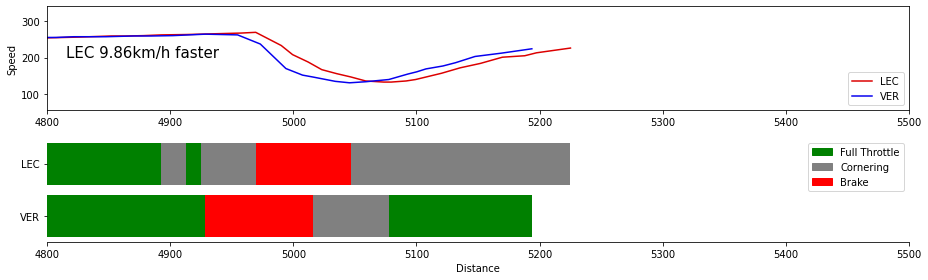

In [ ]:
# set up
plt.rcParams["figure.figsize"] = [13, 4]
plt.rcParams["figure.autolayout"] = True

telemetry_colors = {
    'Full Throttle': 'green',
    'Cornering': 'grey',
    'Brake': 'red',
}

fig, ax = plt.subplots(2)

### Lineplot for speed 
ax[0].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label=driver_1, color=ff1.plotting.team_color(team_driver_1))
ax[0].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label=driver_2, color=ff1.plotting.team_color(team_driver_2))

# Speed difference
ax[0].text(distance_min + 15,200, speed_text, fontsize = 15)

ax[0].set(ylabel='Speed')
ax[0].legend(loc="lower right")

#### Horizontal barplot for telemetry
for driver in [driver_1, driver_2]:
    driver_actions = all_actions.loc[all_actions['Driver'] == driver]
    
    previous_action_end = 0
    for _, action in driver_actions.iterrows():
        ax[1].barh(
            [driver], 
            action['DistanceDelta'], 
            left=previous_action_end, 
            color=telemetry_colors[action['CurrentAction']]
        )
        
        previous_action_end = previous_action_end + action['DistanceDelta']

### Styling of the plot   
# Set x-label
plt.xlabel('Distance')

# Invert y-axis 
plt.gca().invert_yaxis()

# Remove frame from plot
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Add legend
labels = list(telemetry_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=telemetry_colors[label]) for label in labels]
ax[1].legend(handles, labels)

# Zoom in on the specific part we want to see
ax[0].set_xlim(distance_min, distance_max)
ax[1].set_xlim(distance_min, distance_max)

# Save the plot
plt.savefig('2022_Abu Dhabi_Q_LEC_vs_VER_Corner_Analysis.png', dpi=300)

In [ ]:
files.download('2022_Abu Dhabi_Q_LEC_vs_VER_Corner_Analysis.png') #Download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>